<h1>Car Price Data EDA, Cleaning, Validation, and Prediction</h1>
<h5>A Jupyter Notebook by Matthew Zenner<h5>

Data sourced from <a href=https://www.kaggle.com/datasets/vijayaadithyanvg/car-price-predictionused-cars>Kaggle</a>

Inspired by a similiar <a href=https://towardsdatascience.com/machine-learning-project-predicting-boston-house-prices-with-regression-b4e47493633d>article</a>.


<h3>Data Exploration and Preprocessing</h3>

In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

# Load the car price dataset from .csv to DataFrame
data = pd.read_csv('https://raw.githubusercontent.com/mattzenner/car_price_prediction/main/car_data.csv')
data

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


The dataset comes with a 'Car_Name' column specifying the model of the vehicle. We will not use this feature in the analysis, so the column is dropped.

In [95]:
data = data.drop('Car_Name', axis=1)

Let's see some descriptive statistics about the numerical features of this dataset.

In [96]:
data.describe()

,Year,Selling_Price,Present_Price,Driven_kms,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.642584,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


Notice how the 'Owner' column has a minimum of 0 and maximum of 3, meaning each vehicle has between 0 and 3 previous owners. We can convert this column to a categorical variable with two possible values, 'New' or 'Used' and rename the column 'History'. We can simultaneously rename other columns for style and clarity. We then verify using the first record.

In [97]:
data = data.rename({'Driven_kms': 'Odometer', 'Selling_type': 'Transaction', 'Owner': 'History', 'Fuel_Type': 'Fuel', 'Selling_Price': 'Sale_Price'}, axis=1)
data['History'] = data['History'].replace(to_replace={0: 'New', 1: 'Used', 2: 'Used', 3: 'Used'})
data.head(1)

,Year,Sale_Price,Present_Price,Odometer,Fuel,Transaction,Transmission,History
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,New


Let's check how many unique values exist in the categorical features.

In [98]:
print(f"        Fuel: {data['Fuel'].nunique()} unique values.")
print(f"     History: {data['History'].nunique()} unique values.")
print(f" Transaction: {data['Transaction'].nunique()} unique values.")
print(f"Transmission: {data['Transmission'].nunique()} unique values.")

        Fuel: 3 unique values.
     History: 2 unique values.
 Transaction: 2 unique values.
Transmission: 2 unique values.


How many instances of each unique value does Fuel have?

In [99]:
data['Fuel'].value_counts()

Petrol    239
Diesel     60
CNG         2
Name: Fuel, dtype: int64

Since only 2 records have value 'CNG' for Fuel, or 0.6645% of the data, let's drop those records. We verify by calling value_counts() again.

In [100]:
data = data.drop(data[data['Fuel'] == 'CNG'].index)
data['Fuel'].value_counts()

Petrol    239
Diesel     60
Name: Fuel, dtype: int64

In [101]:
data['Transaction'].value_counts()

Dealer        193
Individual    106
Name: Transaction, dtype: int64

In [102]:
data['Transmission'].value_counts()

Manual       259
Automatic     40
Name: Transmission, dtype: int64

In [103]:
data['History'].value_counts()

New     288
Used     11
Name: History, dtype: int64

Let's inspect the Odometer values for all New vehicles.

In [105]:
new_vehicles = data[data['History'] == 'New']
print(f"Percent of records with New: {len(new_vehicles) / len(data) * 100.0:.2f}%")
new_vehicles = new_vehicles[new_vehicles['Odometer'] >= 322]
print(f"Percent of records with New and more than 322km driven: {len(new_vehicles) / len(data) * 100.0:.2f}%")

Percent of records with New: 96.32%
Percent of records with New and more than 322km driven: 96.32%


Since 96.32% of all records have value 'New' for history, and the same number have New and more than 322km or 200 miles, we conclude that the History column is better off omitted due to its inconsistency with Odometer values.

In [106]:
data = data.drop(['History'], axis=1)

Next, we use a pair plot to visually compare quantitative features.

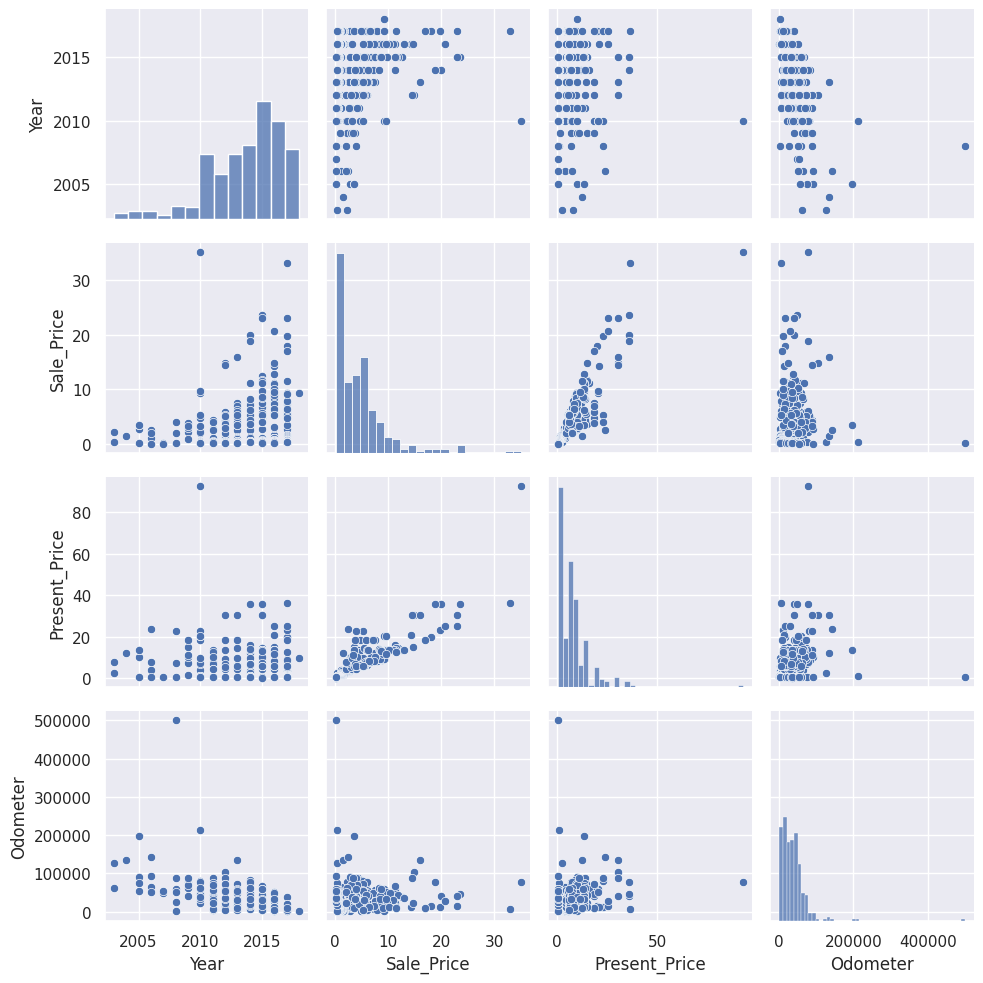

In [107]:
sns.pairplot(data, height=2.5)
plt.tight_layout()

From the pair plot above, we see suspected outliers in the quantitative columns of the data.
In order to quantify our suspicion, we compute the skewness of 'Odometer', 'Sale_Price', 'Present_Price', and 'Year'.

In [108]:
year_skew = data['Year'].skew()
odometer_skew = data['Odometer'].skew()
selling_skew = data['Sale_Price'].skew()
present_skew = data['Present_Price'].skew()

print(f"Year skew:          {year_skew:.2f}")
print(f"Odometer skew:      {odometer_skew:.2f}")
print(f"Sale Price skew:    {selling_skew:.2f}")
print(f"Present Price skew: {present_skew:.2f}")

Year skew:          -1.25
Odometer skew:      6.42
Sale Price skew:    2.48
Present Price skew: 4.07


The skewness of these columns tells us they are all right-skewed, except for 'Year', indicating the presence of excessively large values.
Let's use histograms and box plots to further inspect the data, specifically for columns 'Odometer', 'Sale_Price', and 'Present_Price'.

[Text(0.5, 0, 'Present_Price (skew 4.071)')]

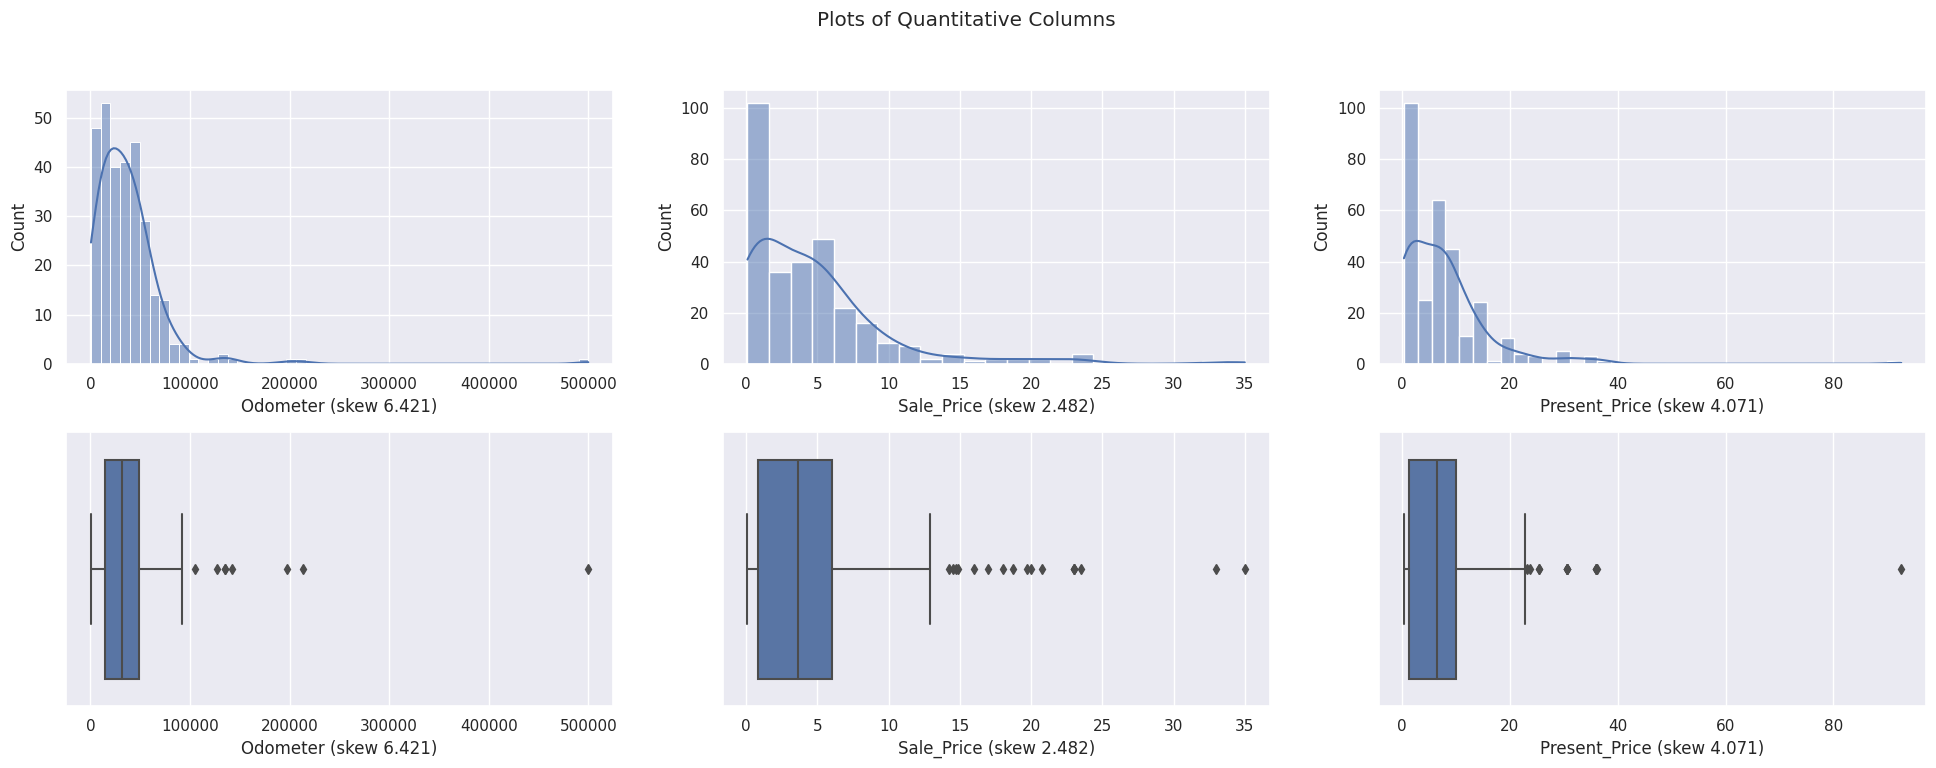

In [109]:
fig, axes = plt.subplots(2, 3, figsize=(24, 8))
plt.subplots_adjust(hspace=0.25)
fig.suptitle('Plots of Quantitative Columns')

sns.histplot(ax=axes[0, 0], data=data, x='Odometer', kde=True).set(xlabel='Odometer (skew {:.3f})'.format(odometer_skew))
sns.histplot(ax=axes[0, 1], data=data, x='Sale_Price', kde=True).set(xlabel='Sale_Price (skew {:.3f})'.format(selling_skew))
sns.histplot(ax=axes[0, 2], data=data, x='Present_Price', kde=True).set(xlabel='Present_Price (skew {:.3f})'.format(present_skew))

sns.boxplot(ax=axes[1, 0], data=data, x='Odometer').set(xlabel='Odometer (skew {:.3f})'.format(odometer_skew))
sns.boxplot(ax=axes[1, 1], data=data, x='Sale_Price').set(xlabel='Sale_Price (skew {:.3f})'.format(selling_skew))
sns.boxplot(ax=axes[1, 2], data=data, x='Present_Price').set(xlabel='Present_Price (skew {:.3f})'.format(present_skew))

Both the histograms and box plots indicate the presence of extreme positive outliers. This is corroborated by high positive skew values. We drop these outliers using z-score. All records with a z-score greater than 3 (a value more than 3 standard deviations away from the mean) for Sale_Price, Present_Price, or Odometer are dropped.

<h3>Removing Outliers</h3>

In [110]:
length_before_outliers = len(data)
data = data[(np.abs(stats.zscore(data[['Sale_Price', 'Present_Price', 'Odometer']])) <= 3).all(axis=1)]
data = data.reset_index(drop=True)

records_removed = length_before_outliers - len(data)
percent_removed = (records_removed / length_before_outliers) * 100
print(f"{records_removed} records ({percent_removed:.2f}% of data) with any outlying values were removed.")

12 records (4.01% of data) with any outlying values were removed.


Let's take a look at our plots again after the outliers have been removed.

[Text(0.5, 0, 'Present_Price (skew 1.280)')]

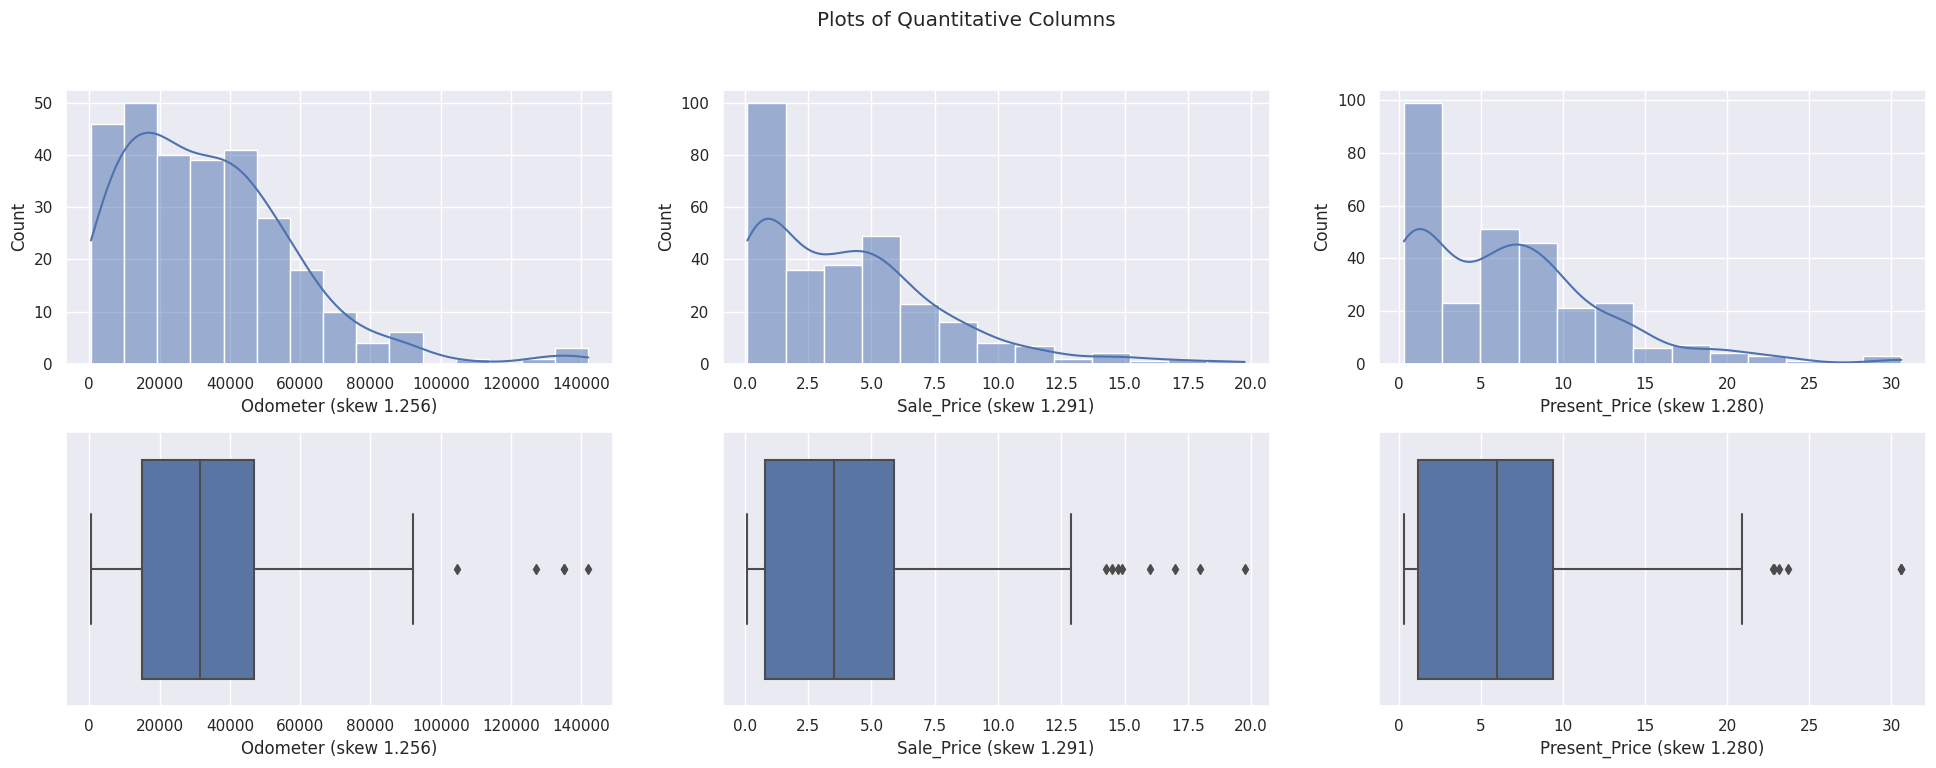

In [111]:
odometer_skew = data['Odometer'].skew()
selling_skew = data['Sale_Price'].skew()
present_skew = data['Present_Price'].skew()

fig, axes = plt.subplots(2, 3, figsize=(24, 8))
plt.subplots_adjust(hspace=0.25)
fig.suptitle('Plots of Quantitative Columns')

sns.histplot(ax=axes[0, 0], data=data, x='Odometer', kde=True).set(xlabel='Odometer (skew {:.3f})'.format(odometer_skew))
sns.histplot(ax=axes[0, 1], data=data, x='Sale_Price', kde=True).set(xlabel='Sale_Price (skew {:.3f})'.format(selling_skew))
sns.histplot(ax=axes[0, 2], data=data, x='Present_Price', kde=True).set(xlabel='Present_Price (skew {:.3f})'.format(present_skew))

sns.boxplot(ax=axes[1, 0], data=data, x='Odometer').set(xlabel='Odometer (skew {:.3f})'.format(odometer_skew))
sns.boxplot(ax=axes[1, 1], data=data, x='Sale_Price').set(xlabel='Sale_Price (skew {:.3f})'.format(selling_skew))
sns.boxplot(ax=axes[1, 2], data=data, x='Present_Price').set(xlabel='Present_Price (skew {:.3f})'.format(present_skew))

<h3>One-hot Encoding</h3>
<h4> change this section to use the sklearn OneHotEncoder </h4>
<a href=https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder>OneHotEncoder</a>

Let's convert the categorical variables into a binary representation using one-hot encoding with the help of <a href=https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python>Stack Overflow</a>

Each categorical column will be split into two columns. For example, Fuel will be replaced by two columns, Petrol and Diesel. If a record had value 'Petrol' in
the original Fuel column, its value in the new Petrol column will be 1 and its value in the new Diesel column will be 0. Other categorical columns will follow the same pattern.

In [112]:
dummies = pd.get_dummies(data.Fuel)
data = pd.concat([data, dummies], axis=1)
data = data.drop(['Fuel'], axis=1)

dummies = pd.get_dummies(data.Transaction)
data = pd.concat([data, dummies], axis=1)
data = data.drop(['Transaction'], axis=1)

dummies = pd.get_dummies(data.Transmission)
data = pd.concat([data, dummies], axis=1)
data = data.drop(['Transmission'], axis=1)

Now let's use some quick summations to check if our one-hot encoding was successful.

In [113]:
print('One-hot encoding validation: ')
print(f"        Fuel: {len(data) == sum(data['Diesel']) + sum(data['Petrol'])}")
print(f" Transaction: {len(data) == sum(data['Dealer']) + sum(data['Individual'])}")
print(f"Transmission: {len(data) == sum(data['Automatic']) + sum(data['Manual'])}")

One-hot encoding validation: 
        Fuel: True
 Transaction: True
Transmission: True


Note that this is not a guaranteed verification as it could still return True if there were two 0s in one column and/or two 1s in another.

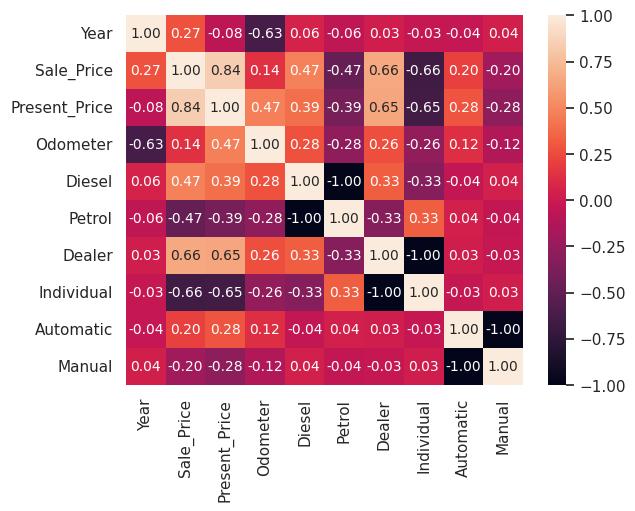

In [114]:
# Calculate and show correlation matrix
cm = np.corrcoef(data.values.T)
sns.set(font_scale=1.0)
hm = sns.heatmap(cm,
                 cbar=True,
                 cmap='rocket',
                 annot=True,
                 square=False,
                 fmt='.2f',
                 annot_kws={'size': 10},
                 yticklabels=data.columns,
                 xticklabels=data.columns)

This correlation matrix provides another opportunity to verify the one-hot encoding. Assuming that each record in the data has a value of 1 for only one of the two new columns resulting from one-hot encoding, and the other column will have value 0, the correlation between those two columns will equal -1.00. We can see this is the case in the above correlation matrix, e.g. for the cell at the intersection of the 'Manual' and 'Automatic' column labels in the lower right corner. If the correlation is not -1.00, we can suspect that there exists some record for which a pair of one-hot columns has the same value. This would be invalid in that each record should only have value 1 in one column of each one-hot pair.

Since we intend to build a model to predict Present_Price, let's look at its row or column in the correlation matrix. We can look at just the row or the column, as they are identical. In this instance, we'll look at the row. Reading across the Present_Price row, in the first cell we can see that it has only a small negative correlation with Year. <br> In the second cell, we find that Present_Price and Sale_Price have a high correlation. It makes sense that the price the car last sold at would strongly correlate with its current price. <br> Next, we can safely ignore the value of 1.00 in the third cell because that is the intersection with Present_Price's own column. <br> The fourth cell indicates some degree of correlation with Odometer. <br> The rest of the cells in the row are the one-hot encoded columns.

<h3> End Outlier Removal and One Hot Encoding, Begin Scaling </h3>

Let's shuffle the data by row to ensure no particular ordering of the data is carried into the model and separate the data into Present_Price (the value to predict) and the features. Verify Present_Price is absent from the columns in data.

In [115]:
data = data.sample(frac=1).reset_index(drop=True)

present_price = data['Present_Price']
data = data.drop('Present_Price', axis = 1)
data.head(1)

,Year,Sale_Price,Odometer,Diesel,Petrol,Dealer,Individual,Automatic,Manual
0,2010,9.25,59000,1,0,1,0,0,1


In [116]:
data_categorical = data[['Diesel', 'Petrol', 'Dealer', 'Individual', 'Automatic', 'Manual']]
data = data.drop(['Diesel', 'Petrol', 'Dealer', 'Individual', 'Automatic', 'Manual'], axis=1)

In [117]:
# https://stackoverflow.com/questions/53306854/adding-standardscaler-of-values-as-new-column-to-dataframe-returns-partly-nans
# https://lifewithdata.com/2022/03/08/what-is-standardscaler-in-sklearn-and-how-to-use-it/

# Scale the data using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data = scaler.fit_transform(data)
data = pd.DataFrame(data)

Opportunity here to further validate that one-hot encoding was successful.

In [118]:
data = pd.concat([data, data_categorical], ignore_index=True, sort=False, axis=1)
data = data.rename(columns={0: 'Year', 1: 'Sale_Price', 2: 'Odometer', 3: 'Diesel', 4: 'Petrol', 5: 'Dealer', 6: 'Individual', 7: 'Automatic', 8: 'Manual'})
data

,Year,Sale_Price,Odometer,Diesel,Petrol,Dealer,Individual,Automatic,Manual
0,-1.283318,1.413277,1.013762,1,0,1,0,0,1
1,0.470550,-0.954376,-0.201640,0,1,0,1,0,1
2,0.119776,-0.803832,-1.092935,0,1,0,1,0,1
3,0.470550,-0.968062,0.973248,0,1,0,1,0,1
4,1.172097,-0.160597,0.182751,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...
282,1.172097,0.660555,-0.517645,0,1,1,0,0,1
283,-1.283318,-0.229026,0.973248,1,0,1,0,0,1
284,-1.283318,-0.393256,0.302427,0,1,1,0,0,1
285,-0.581771,0.496324,0.892221,0,1,1,0,0,1


<h3>Model Training and Inference</h3>

<h4>Shared Prep</h4>

In [119]:
from sklearn.metrics         import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics         import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm             import SVR

# reassign data to features for clarity
features = data

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, present_price, test_size=0.2, random_state = 42)

# Create cross-validation sets from the training data
cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.10, random_state = 42)

# Set the scoring function as r2_score
scoring_fnc = make_scorer(r2_score)

<h4>Linear</h4>

In [120]:
from sklearn.linear_model    import LinearRegression

regressor_linear = LinearRegression()

# Create a dictionary of parameter settings for grid search cross-validation
params_linear = [ {'positive': [True, False]} ]

# Create the grid search cross-validation object
grid_linear = GridSearchCV(estimator=regressor_linear, param_grid=params_linear, scoring=scoring_fnc, cv=cv_sets, n_jobs=1, verbose=1)

# Fit the grid search object to the data to compute the optimal model
grid_linear = grid_linear.fit(X_train, y_train)

# Return the optimal model after fitting the data
model_linear = grid_linear.best_estimator_

Fitting 10 folds for each of 2 candidates, totalling 20 fits


In [121]:
# https://towardsdatascience.com/model-evaluation-in-scikit-learn-abce32ee4a99

y_pred = model_linear.predict(X_test)

# Print the parameters and cross-validation score of the best model.
# Evaluate the model using R^2, Mean Absolute Error, and Root Mean Squared Error, and its own .score() method.
print("The parameters of the best Linear Regression model were: ")
for key in grid_linear.best_params_.keys():
    print(f"{key}: {grid_linear.best_params_[key]}")
print()
print(f"The cross-validation score of the best Decision Tree model was: {grid_linear.best_score_:.3f}")
print(f"     R^2: {r2_score(y_test, y_pred):.3f}")
print(f"     MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"    RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f".score(): {model_linear.score(X_test, y_pred):.3f}")

The parameters of the best Linear Regression model were: 
positive: False

The cross-validation score of the best Decision Tree model was: 0.815
     R^2: 0.780
     MAE: 1.681
    RMSE: 2.497
.score(): 1.000


<h4>Decision Tree</h4>

In [122]:
from sklearn.tree            import DecisionTreeRegressor

regressor_tree = DecisionTreeRegressor()

# Create a dictionary of parameter settings for grid search cross-validation
params_tree = [ {'max_depth': [n for n in range(1, 51)]} ]

# Create the grid search cross-validation object
grid_tree = GridSearchCV(estimator=regressor_tree, param_grid=params_tree, scoring=scoring_fnc, cv=cv_sets, n_jobs=1, verbose=1)

# Fit the grid search object to the data to compute the optimal model
grid_tree = grid_tree.fit(X_train, y_train)

# Return the optimal model after fitting the data
model_tree = grid_tree.best_estimator_

Fitting 10 folds for each of 50 candidates, totalling 500 fits


In [123]:
# https://towardsdatascience.com/model-evaluation-in-scikit-learn-abce32ee4a99

y_pred = model_tree.predict(X_test)

# Print the parameters and cross-validation score of the best model.
# Evaluate the model using R^2, Mean Absolute Error, and Root Mean Squared Error, and its own .score() method.
print("The parameters of the best Decision Tree model were: ")
for key in grid_tree.best_params_.keys():
    print(f"{key}: {grid_tree.best_params_[key]}")
print()
print(f"The cross-validation score of the best Decision Tree model was: {grid_tree.best_score_:.3f}")
print(f"     R^2: {r2_score(y_test, y_pred):.3f}")
print(f"     MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"    RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f".score(): {model_tree.score(X_test, y_pred):.3f}")

The parameters of the best Decision Tree model were: 
max_depth: 44

The cross-validation score of the best Decision Tree model was: 0.869
     R^2: 0.676
     MAE: 1.565
    RMSE: 3.031
.score(): 1.000


<h4>SVR</h4>

In [124]:
# Create the model object
regressor_svr = SVR()

# Create a dictionary of parameter settings for grid search cross-validation
params_svr = [   {'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'epsilon': [0.001, 0.01, 0.1, 1.0, 10.0]},
              {'kernel': ['poly'], 'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'epsilon': [0.001, 0.01, 0.1, 1.0, 10.0], 'degree': [2, 3, 4]},
            {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'epsilon': [0.001, 0.01, 0.1, 1.0, 10.0]},
           {'kernel': ['sigmoid'], 'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'epsilon': [0.001, 0.01, 0.1, 1.0, 10.0]}
           ]



In [125]:
# Create the grid search cross-validation object
grid_svr = GridSearchCV(estimator=regressor_svr, param_grid=params_svr, scoring=scoring_fnc, cv=cv_sets, n_jobs=1, verbose=1)

# Fit the grid search object to the data to compute the optimal model
grid_svr = grid_svr.fit(X_train, y_train)

# Return the optimal model after fitting the data
model_svr = grid_svr.best_estimator_

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


In [126]:
# https://towardsdatascience.com/model-evaluation-in-scikit-learn-abce32ee4a99

y_pred = model_svr.predict(X_test)

# Print the parameters and cross-validation score of the best model.
# Evaluate the model using R^2, Mean Absolute Error, and Root Mean Squared Error, and its own .score() method.
print("The parameters of the best SVR model were: ")
for key in grid_svr.best_params_.keys():
    print(f"{key}: {grid_svr.best_params_[key]}")
print()
print(f"The cross-validation score of the best SVR model was: {grid_svr.best_score_:.3f}")
print(f"     R^2: {r2_score(y_test, y_pred):.3f}")
print(f"     MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"    RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f".score(): {model_svr.score(X_test, y_pred):.3f}")

The parameters of the best SVR model were: 
C: 10.0
degree: 3
epsilon: 0.1
kernel: poly

The cross-validation score of the best SVR model was: 0.918
     R^2: 0.413
     MAE: 1.644
    RMSE: 4.078
.score(): 1.000


<h3>Predicting on new data</h3>

Now that we have a trained, tested, and scored model, let's try it out on some completely new data. Three example vehicles are created, using the 25%, 50%, and 75% quartile values for the numerical features (Present_Price is omitted as it is the value we have trained the model to predict). Next, these examples are scaled, and values for the one-hot columns are introduced. Finally, the predicted price for each vehicle is printed.

<h5>Shared Prep</h5>

In [127]:
# Produce a matrix for example data
example_data = [[2009, 0.9, 15000], # example 1
               [2013, 3.6, 32000], # example 2
               [2017, 6.0, 49000]] # example 3

example_data = scaler.transform(example_data)
one_hots = np.array([ [0, 1, 0, 1, 0, 1], [0, 1, 0, 1, 1, 0], [1, 0, 1, 0, 0, 1] ])
example_data = np.append(example_data, one_hots, axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<h5>Linear</h5>

In [128]:
print('Predicting with Linear Regression')
for i, price in enumerate(model_linear.predict(example_data)):
    print(f"Predicted present price for example {i+1}'s car: {price*100000:,.2f} rupee")

Predicting with Linear Regression
Predicted present price for example 1's car: 187,849.38 rupee
Predicted present price for example 2's car: 720,474.60 rupee
Predicted present price for example 3's car: 853,338.49 rupee


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


<h5>Decision Tree</h5>

In [129]:
print('Predicting with Decision Tree')
for i, price in enumerate(model_tree.predict(example_data)):
    print(f"Predicted present price for example {i+1}'s car: {price*100000:,.2f} rupee")

Predicting with Decision Tree
Predicted present price for example 1's car: 78,700.00 rupee
Predicted present price for example 2's car: 679,000.00 rupee
Predicted present price for example 3's car: 806,000.00 rupee


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


<h5>SVR</h5>

In [130]:
print('Predicting with SVR')
for i, price in enumerate(model_svr.predict(example_data)):
    print(f"Predicted present price for example {i+1}'s car: {price*100000:,.2f} rupee")

Predicting with SVR
Predicted present price for example 1's car: 126,769.38 rupee
Predicted present price for example 2's car: 447,762.18 rupee
Predicted present price for example 3's car: 847,423.58 rupee


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


<h2>To Do</h2>

 * Sale_Price and Present_Price are given in units of lakh Indian Rupees
 * multiply these columns by 100,000 to change the units to just Indian Rupees
 * convert to USD using either the present exchange rate, or the exchange rate on the date the data was posted to Kaggle
<br>
<br>
 * create global variable for random_state, set to 42
 * add Year column to histograms and box plots section
 * remove present_price column from data at the beginning of the model training and prediction section, after EDA, in order to fit the scaler on 3 features (year, sale_price, odometer) and avoid scaling Present_Price (which does not need to be scaled as it is the target and not a feature)
 * change one-hot encoding validation print to use fstrings
 * change from grid search CV to Random Parameter Optimization and plot the R^2 as n_iter is increased
 * switch from StandardScaler to MinMaxScaler
<br>
<br>
 * change one-hot encoding from pd.dummies to sklearn OneHotEncoder
 * then change example data to start as categorical strings and transform them with OneHotEncoder